#Final Report - Introduction to Deep Learning


Dor Shmuel 312179971

Moshe Davidian 201402856


# Lung Damages X-Ray Classifier Project -2nd stage

### 1. import Libraries

In [ ]:
pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip

In [ ]:
import time
import copy
import torch
import torchvision
from torchvision import models
from torchsummary import summary
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsampler import ImbalancedDatasetSampler
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os.path
import os as path
import shutil
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from datetime import datetime

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
!nvidia-smi
device

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#Dataset 
As we described earlier, our data for the 2nd stage is comprised from 4 classes of images:

1.	**Normal**: 10192 images 
2.	**Covid**:3616 images
3.	**Viral Pneumonia**: 1345 images
4.	**Lung Opacity**: 6012 images 

**Pre-Processing:**

In order to feed the data into the networks we have preprocessed it as follows:
Arrangement of the data into folders and partition of the data to 70% of training data, 20% of Test data and 10% of validation data.

Pre-Processing of the images (most based on the article in (Vu, 2021)):

a.	Resize: size = (3,224,224)

b.	Augmentation (SAXENA, 2021) (Elgendi, Nasir, Tang, & Smith, 2021) - only if needed.

c.	Convert to Tensor.

d.	Normalize the images with mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225])

e.	Conversion to DataLoader type. 


### 2. Data Arrngment

**In the first time (only):**

Change to **Arrange=True**

Change to **root_dir=**'the data path' 

in this path, the data should be in "/Data/COVID-19_Radiography_Dataset"

i.e. "My_path/Data/COVID-19_Radiography_Dataset"

In [ ]:
def remove_pre_suf_int(name,label):
  return int(name[len(label+'-'):-len('.png')])

In [ ]:
def Data_arrangement_Initial(root_dir,labels,Arrange=False):
  if Arrange:
    Data=root_dir+"/Data/COVID-19_Radiography_Dataset" #change to the right folder
    # path declaration
    Data_labels_paths=[Data+'/'+label_name for label_name in labels]
    train_path=[root_dir+"/training_set"+'/'+label_name for label_name in labels]
    test_path=[root_dir+"/test_set"+'/'+label_name for label_name in labels]
    valid_path=[root_dir+"/valid_set"+'/'+label_name for label_name in labels]
    for label_idx,label in enumerate(labels):
      images_in_dir=[remove_pre_suf_int(name,label) for name in os.listdir(Data_labels_paths[label_idx])]
      images_in_dir.sort()
      num_of_images=len(images_in_dir)
      First_index=int(images_in_dir[0])
      print(images_in_dir)
      for image_idx in range(num_of_images): # read all images from the folder
        idx=First_index+image_idx   
        if idx > num_of_images:
          break;
        addon_path="/{}-{}.png".format(label,idx)
        if idx % 10 < 7:  # 0-6   70% trian
          dest=train_path
        elif idx % 10 == 7: #  7     10% val
          dest=valid_path
        else:  # 8-9  20% test
          dest=test_path
        print(os.path.isfile(Data_labels_paths[label_idx]+addon_path))
        if os.path.isfile(Data_labels_paths[label_idx]+addon_path):
          print(idx)
          shutil.copy(Data_labels_paths[label_idx]+addon_path, dest[label_idx]+addon_path)
    return "Forward Some data",train_path,test_path,valid_path
  else:
    return "nothing Forwarded"

  
Arrange= False
root_dir='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/COVID-19_Radiography_Dataset' #change to the right folder
labels=['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']  
print(Data_arrangement_Initial(root_dir,labels))

In [ ]:
def Data_arrangement(root_dir,labels):
  # Used to test the effect of balanced data
  # path declaration
  Data_labels_paths=[root_dir+'/'+label_name for label_name in labels]
  train_path=[root_dir+"/training_set_balance"+'/'+label_name for label_name in labels]
  test_path=[root_dir+"/test_set_balance"+'/'+label_name for label_name in labels]
  valid_path=[root_dir+"/valid_set_balance"+'/'+label_name for label_name in labels]
  
  for label_idx,label in enumerate(labels):
    images_in_dir=[name for name in os.listdir(Data_labels_paths[label_idx])]
    images_in_dir.sort()
    print(images_in_dir)
    for idx,image in enumerate(images_in_dir[:1000]):  # read balance amount of images from each folder
      if idx % 10 < 7:  # 0-6  70% trian
        dest=train_path
      elif idx % 10 == 7:  #  7   10% val 
        dest=valid_path
      else:  # 8-9   20% test
        dest=test_path

      if not (os.path.isfile(dest[label_idx] + '/' + image)) and (os.path.isfile(Data_labels_paths[label_idx] + '/' + image)):
        shutil.copy(Data_labels_paths[label_idx] + '/' + image, dest[label_idx])
  return train_path,test_path,valid_path
  

Arrange= False
if Arrange:
  root_dir='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/COVID-19_Radiography_Dataset' #change to the right folder
  labels=['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']  
  print(Data_arrangement(root_dir,labels))

### 3. Data Assignment and Visualization

#### 3.1. Data Assignment

In [ ]:
# Data Assignment 
input_size  = 256*256  # images are 256x256 pixels
output_size = 4      # there are 4 classes - Normal, Covid, Lung_Opacity, Viral Pneumonia
def get_data(data_dir):
  train_transform =transforms.Compose([  
      transforms.Resize(size = (224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])

  test_transform = transforms.Compose([
      transforms.Resize(size = (224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])

  train_set = datasets.ImageFolder(data_dir + '/training_set' , transform=train_transform)
  test_set = datasets.ImageFolder(data_dir + '/test_set', transform=test_transform)
  val_set = datasets.ImageFolder(data_dir + '/valid_set', transform=test_transform)
  #DataLoader
  train =  torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True)
  test =  torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
  val =  torch.utils.data.DataLoader(val_set, batch_size=50, shuffle=True)  

  dataloaders={'train':train,'val':val,'test':test}
  dataset_sizes = {'train':len(train_set),'val':len(val_set),'test':len(test_set)}
  class_names = train_set.classes

  return dataloaders,dataset_sizes,class_names,train_set

# Pathes of Data
save_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/Saved_data_4C' #change to the right folder
data_dir ='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/COVID-19_Radiography_Dataset_4C' #change to the right folder

# Prepare Data
dataloaders,dataset_sizes,class_names,train_set=get_data(data_dir)

#Save Data
torch.save(dataloaders,save_path + '/dataloaders.pt')
torch.save(train_set,save_path + '/trainset.pt')
torch.save(dataset_sizes,save_path + '/dataset_sizes.pt')
torch.save(class_names,save_path + '/class_names.pt')

train,val,test=dataloaders['train'],dataloaders['val'],dataloaders['test']


In the first time we read the pictures and save them as data so that the next time they will load faster.

In [ ]:
# load Data
save_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/Saved_data_4C' #change to the right folder
dataloaders=torch.load(save_path + '/dataloaders.pt')
train_set = torch.load(save_path + '/trainset.pt')
dataset_sizes=torch.load(save_path + '/dataset_sizes.pt')
class_names=torch.load(save_path + '/class_names.pt')
train,val,test=dataloaders['train'],dataloaders['val'],dataloaders['test']

##### 3.1.1.sanity check

In [ ]:
 # Data types
# number of images
print("train size=",dataset_sizes['train'])
print("val size=",dataset_sizes['val'])
print("test size=",dataset_sizes['test'])

# num of training Batches
print('Num of training batches', len(train))
print("Num of val batches", len(val))
print("Num of test batches", len(test))

#### 3.2.Data Visualization

In [ ]:
images,_=iter(train).next()
print(images.shape)

In [ ]:
def train_imshow(data, classes, num_Img_show):
    num_Img_show=5
    classes=tuple(classes)
    dataiter = iter(data)
    images, labels = dataiter.next()
    fig, axes = plt.subplots(figsize=(10, 4), ncols=num_Img_show)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    for i in range(num_Img_show):
      ax = axes[i]
      ax.imshow((images[i].permute(1, 2, 0)* std + mean)) 
      ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
    plt.show()

def test_imshow(data, classes, num_Img_show):
    # the batch size of the test set is one hence we write new func
    classes=tuple(classes)
    dataiter = iter(data)
    #images, labels = dataiter.next()
    fig, axes = plt.subplots(figsize=(10, 4), ncols=num_Img_show)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    for i in range(num_Img_show):
      images, labels = dataiter.next()
      ax = axes[i]
      ax.imshow((images[0].permute(1, 2, 0)* std + mean)) 
      ax.title.set_text(' '.join('%5s' % classes[labels[0]]))
    plt.show()


classes=train_set.classes
num_Img_show=5
print("Train images :")
train_imshow(train,classes, num_Img_show)
print("Test images :")
test_imshow(test,classes, num_Img_show)  # test batch_size=1

In [ ]:
def visualize_model(model, num_images=6):
  model.eval()
  images_so_far = 0
  fig = plt.figure()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]),'Original: {}'.format(class_names[labels[j]]))
        imshow(inputs.cpu().data[j])

#Challenges/Limitations
Our Main challenge in this task is to deal/learning from unbalanced data (Jason, 2021)- in the First stage the Normal data is 3 times greater than the COVID-19 data. In the second stage, we notice that the amount of data for each label is diverse.

There are several ways to address that Imbalanced data challenge, as presented in (Wu & Radewagen, 2021) (Borda, 2021).

In this project we will define the right evaluation **metrics**, we will use different **Regularization** techniques such as **Early Stoppings**, **Dropout** and **Batch Normalization** layers, learning rate and weight **decay**, Reduction the **Network Capacity**, we will define and test different **Architectures**, we will use **Resampling** and we will integrate **Augmentations** for both on fly and non-on fly preprocessing methods.


#Metrices stage 2

We will present evaluation matrices for multiclass classification problem, which lead us to insights while dealing with imbalanced data.

There are several methods for this kind of evaluation which presented in, while the key for those metrics is based dividing the multiclass problem into several binary problems i.e., generalization of the 2nd classes evaluation metrics presented above such as True/False positive, True/False Negative, Sensitivity etc.

The overall performance evaluation will then be calculated using the **macro averaging** (Vaughan, 2021) and the **weighted macro averaging** by calculating the binary performance measures separately for each two classes comparison and taking the average/weighted average of the obtained measures.

In order to define our evaluation metrics for each relevant class we will set our problem into binary problem which means we will consider our multiclass predictions down to just the relevant class and 1 class which represent all other class.


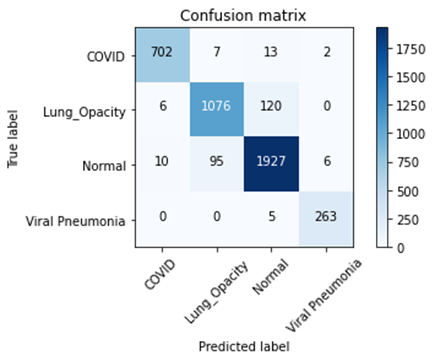

Each element Class_(i,j) in the matrix describes the number of instances that were classified as class j but belongs to class i. 

C_("COVID","COVID"): represent the number of "COVID-19" samples that were predicted as " COVID-19".

C_("COVID","Opacity"): represent the number of "COVID-19" samples that were predicted as "Lung opacity".

C_("COVID","NORMAL"): represent the number of "COVID-19" samples that were predicted as "Normal".

C_("COVID","Pneumonia"): represent the number of "COVID-19" samples that were predicted as "Viral Pneumonia".

And so on..

in our Case we deal with 4 class so we have matrix in the size of N^4x4 where the sum of all elements in the matrix is equal to the number of total samples used for test data (Kautza, Cristian, & F.Pasluosta, 2017).

* The full metrics list in the report


##Loss criterion 
Cross-entropy loss is a loss function widely used for multi-class classification problems. It’s built on the concept of cross-entropy, which is a measurement of two or more probability vectors (often with one of them being one-hot encoded labels in datasets). It penalizes the error of the prediction when it’s too much ‘away’ from the target with the log curve (loss increase dramatically when the distance becomes bigger similar to square error). Cross-entropy loss is usually used with a soft-max activation function.


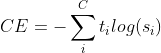

### Train Model Function

In [ ]:
classes=train_set.class_to_idx
classes

In [ ]:
classes=train_set.class_to_idx
occurnces={train_set.classes[i]:train_set.targets.count(i) for i in range(len(train_set.classes))}
occurnces

confusion matrix allows visualization of the performance of network 

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  #print the confusion matrix in nice way
    print("\n\n")
    print("Confusion Matrix")
    print("-"*17)
    printnorm=False
    if printnorm:
      if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
          print("Normalized confusion matrix")
      else:
          print('Confusion matrix, without normalization')
      print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def get_confusion_matrix(model,data):
  # return confusion matrix and report
  model.eval() # annotate model for evaluation
  allpreds = []
  alllabels = []
  for imgs, labels in data:
    imgs = imgs.to(device)
    labels = labels.to(device)
    output = model(imgs) # We don't need to run torch.softmax
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    
    allpreds.extend(pred)
    alllabels.extend(labels)
    
  alllab = [x.tolist() for x in alllabels]
  allpre = [x.tolist()[0] for x in allpreds]
  CM = confusion_matrix(alllab,allpre,list(train_set.class_to_idx.values()))
  CR = classification_report(alllab,allpre,target_names= list(train_set.class_to_idx.keys()))
  
  return CM, CR

def get_specificity(cm, classes):
  # calculate the specifiticy from the confusion matrix
  specificity = [0] * len(classes)
  
  for c in range(len(classes)):
    tn=0
    fp=0
    for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
        if i!=c and j!=c:
          tn+=cm[i,j]
        elif i!=c and j==c: ### we should run only on the rows
          fp+=cm[i,j]
    specificity[c] = tn/(tn+fp)
  return specificity

def print_specificity(specificity, classes):
  print("Specificity\n----------")
  for i,c in enumerate(classes):
    print('%15s  ' % c, "%.4f" % specificity[i])
  

In [ ]:
def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs, losses_valid):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.plot(iters, losses_valid, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,
                checkpoint_path= '/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C/ckpt-{}.pk'):
               
  
  '''
  'C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C

  If you want to **checkpoint** your model weights (i.e. save the
    model weights to Google Drive), then the parameter
    `checkpoint_path` should be a string path with `{}` to be replaced
    by the iteration count:

    For example, calling 

    >>> run_pytorch_gradient_descent(model, ...,
            checkpoint_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-{}.pk')

    will save the model parameters in Google Drive every 500 iterations.
    You will have to make sure that the path exists (i.e. you'll need to create
    the folder Intro_to_Deep_Learning, mlp, etc...). Your Google Drive will be populated with files:

    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk
    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-1000.pk
    - ...

    To load the weights at a later time, you can run:

    >>> model.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk'))

    This function returns the training loss, and the training/validation accuracy,
    which we can use to plot the learning curve.
  '''
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  loss_val=[]
  loss_val_iter=[]
  loss_train=[]
  loss_train_iter=[]
  acc_val=[]
  acc_train=[]
  iters=[]
  iter=0
  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      #print('-' * 10)
      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          maxlen=0
          for inputs, labels in dataloaders[phase]:
              maxlen+=1
              iter+=1
              print(iter)
              inputs = inputs.to(device)
              labels = labels.to(device)
              # zero the parameter gradients
              optimizer.zero_grad()
              # print(labels.shape)
              ########### forward ##############
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)
                  iters.append(iter)
                  if phase == 'train':
                    loss_train_iter.append(float(loss)/labels.shape[0])  # compute *average* loss
                  else:
                    loss_val_iter.append(float(loss)/labels.shape[0])  # compute *average* loss
              ########### backward + optimize only if in training phase #######
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()
              #if (checkpoint_path is not None) and iter%10000==0 and phase == 'train':
                #torch.save(model.state_dict(), checkpoint_path.format(iter))
                #print('saved-{}'.format(iter))
              # statistics
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
          if phase == 'train':
              scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = running_corrects.double() / dataset_sizes[phase]
          if phase == 'train':
            loss_train.append(epoch_loss)
            acc_train.append(epoch_acc)
          else:
            loss_val.append(epoch_loss)
            acc_val.append(epoch_acc)


          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
              phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
              torch.save(model.state_dict(), checkpoint_path.format(epoch)+'_best_model_wts')
      plot_learning_curve(list(range(epoch+1)), loss_train, list(range(epoch+1)), acc_train, acc_val, loss_val)
      print()
      print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  train_statistics=(loss_train,acc_train,loss_train_iter)
  val_statistics=(loss_val,acc_val,loss_val_iter)
  return model,train_statistics,val_statistics

In [ ]:
def printbestacc(statistics):
  # print the epoces acc and find the max acc
  max = 0
  index=0
  for i,x in enumerate(statistics):
    print("Epoce",i,",  acc =",float(x))
    if float(x)>max:
      index, max = i, float(x)
  print("Best Acc in epoce",index," - ",max)

In [ ]:
def Run_Simulation(architecture, architecture_name, num_epochs,n_features,output_size,optimizer_name,lr_val,weight_decay_val,step_size_val,gamma_val,momentum_val,checkpoint_optimizer_path,sim_num,load_flag = False,loading_path=None):
  # One function that unifies the running of the network and the required prints
  start = datetime.now()
  
  print("Simulation num  -", sim_num)
  print("Architecture  -", architecture_name)
  print("Optimizer -", optimizer_name, "\t lr value -", lr_val, "\t Weight decay value -", weight_decay_val)
  print("Step size value -", step_size_val, "\t gamma value -",gamma_val, "\t momentum value -",momentum_val)
  print("Num of epochs -", num_epochs)
  print("\nStart trainig:\n")
  CNN_model=architecture(3,n_features,output_size)
  CNN_model = CNN_model.to(device)
  if load_flag== True:
    CNN_model.load_state_dict(torch.load(checkpoint_optimizer_path+loading_path))
  #if criterion == "CrossEntropy":
  criterion_CNN = nn.CrossEntropyLoss()
  if optimizer_name == "Adam":
    optimizer = optim.Adam(CNN_model.parameters(), lr=lr_val,weight_decay=weight_decay_val)
  elif optimizer_name == "SGD":
    optimizer = optim.SGD(CNN_model.parameters(), lr=lr_val,momentum=momentum_val)
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size_val, gamma=gamma_val)

  date = datetime.now().strftime("%d/%m/%Y")
  #'/ckpt_1.07.21_CNN_1st_try_dropbatch_add-{}_64_0.0001_.pk'
  # checkpoint_of_sim = '/ckpt_' + date + '_' + architecture_name + '_' + sim_num +'.pk'
  CNN_model,train_statistics,val_statistics = train_model(CNN_model, criterion_CNN, optimizer, exp_lr_scheduler,num_epochs) #,checkpoint_path=checkpoint_optimizer_path)
  plot_learning_curve(np.array(range(num_epochs)), train_statistics[0], np.array(range(num_epochs)), train_statistics[1], val_statistics[1], val_statistics[0])
  printbestacc(val_statistics[1])
  CM, CR = get_confusion_matrix(CNN_model,test)
  print("Report")
  print("-"*7)
  print(CR)
  print_specificity(get_specificity(CM, list(train_set.class_to_idx.keys())),list(train_set.class_to_idx.keys()))
  time.sleep(10)
  plot_confusion_matrix(CM, list(train_set.class_to_idx.keys()))
  end = datetime.now()
  print("Time to run simulation", sim_num, ":", end-start)
  print('-' * 50)
  print("\n\n")




#Benchmark 

##ResNet 18

As in the 1st stage, we used the RasNet18 as a benchmark for comparison in order to evaluate out models.

The architecture of ResNet18 for a given input image with size 3x224x24 described as above.

As before, In order to train Resnet for our classification task, we used the following settings:

a.	We replaced the Fully connected layer with layer with n features output and 2 outputs.

b.	We used the Cross Entropy loss as a Criterion.

c.	We used SGD with momentum 0.7 as our Optimizer and learning rate decay starting from lr=0.001.


In [ ]:
ResNet18 = models.resnet18(pretrained = True)
ResNet18.fc = torch.nn.Linear(in_features = 512, out_features = 4)
ResNet18 = ResNet18.to(device)
checkpoint_ResNet18_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C/Weights_ResNet18'

##### balanced data + SGD + Momentum 0.7 + lr 0.001

In [ ]:
ResNet18 = models.resnet18(pretrained = True)
ResNet18.fc = torch.nn.Linear(in_features = 512, out_features = 4)
ResNet18 = ResNet18.to(device)
criterion_ResNet18 = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ResNet18 = optim.SGD(ResNet18.parameters(), lr=0.001, momentum=0.7)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ResNet18, step_size=7, gamma=0.1)
num_epochs=20
checkpoint_ResNet18_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_ResNet18'
# ResNet18.load_state_dict(torch.load('/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/ckpt-500.pk'))
ResNet18,train_statistics,val_statistics = train_model(ResNet18, criterion_ResNet18,
                                                       optimizer_ResNet18, exp_lr_scheduler,
                                                       num_epochs,checkpoint_path=checkpoint_ResNet18_path+'/ckpt_23_06_-{}.pk')                    

In [ ]:
printbestacc(val_statistics[1])

In [ ]:
plot_learning_curve(np.array(range(num_epochs)), train_statistics[0], np.array(range(num_epochs)), train_statistics[1], val_statistics[1], val_statistics[0])

In [ ]:
CM, CR = get_confusion_matrix(ResNet18,test)

print("Report")
print("-"*7)
print(CR)

plot_confusion_matrix(CM, list(train_set.class_to_idx.keys()))


##### imbalanced data + SGD + Momentum 0.9 + lr 0.001

In [ ]:
## ResNet for imbalanced data
ResNet18 = models.resnet18(pretrained = True)
ResNet18.fc = torch.nn.Linear(in_features = 512, out_features = 4)
ResNet18 = ResNet18.to(device)
criterion_ResNet18 = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ResNet18 = optim.SGD(ResNet18.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ResNet18, step_size=12, gamma=0.1)
num_epochs=20
checkpoint_ResNet18_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C/Weights_ResNet18'
# ResNet18.load_state_dict(torch.load('/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/ckpt-500.pk'))
ResNet18,train_statistics,val_statistics = train_model(ResNet18, criterion_ResNet18,
                                                       optimizer_ResNet18, exp_lr_scheduler,
                                                       num_epochs,checkpoint_path=checkpoint_ResNet18_path+'/ckpt_03_07_-{}.pk')
printbestacc(val_statistics[1])
plot_learning_curve(np.array(range(num_epochs)), train_statistics[0], np.array(range(num_epochs)), train_statistics[1], val_statistics[1], val_statistics[0])
CM, CR = get_confusion_matrix(ResNet18,test)
print("Report")
print("-"*7)
print(CR)
plot_confusion_matrix(CM, list(train_set.class_to_idx.keys()))
print_specificity(get_specificity(CM, list(train_set.class_to_idx.keys())),list(train_set.class_to_idx.keys()))

In [ ]:
  print_specificity(get_specificity(CM, list(train_set.class_to_idx.keys())),list(train_set.class_to_idx.keys()))

##### **ResNet18 - Conclusions**
1. After 10 epochs the model accuracy is steady.
2. Test accuarcy : 93%
3. Trainable params: 11,178,564
 

We can observe that ResNet achieves quite good "**Lung opacity**" recall.

In [ ]:
summary(ResNet18, (3, 224, 224))

##VGG16
We also used VGG16 as a benchmark to evaluate our models.

The architecture of VGG16 for a given input image with size 3x224x24 described as above.

As before, In order to train VGG16 for our classification task, we used the following settings:

a.	We replaced the Fully connected layer with layer with n features output and 4 outputs.

b.	We used the Cross Entropy loss as a Criterion.

c.	We used SGD with momentum 0.7 as our Optimizer and learning rate decay starting from lr=0.001.


In [ ]:
vgg16 = models.vgg16(pretrained = True)
vgg16.fc = torch.nn.Linear(in_features = 512, out_features = 4)
vgg16 = vgg16.to(device)
checkpoint_VGG16_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_VGG16'
summary(vgg16, (3, 224, 224))
vgg16.classifier

##### imbalanced data + SGD + Momentum 0.9 + lr 0.001

In [ ]:
#unbalnced data
vgg16 = models.vgg16(pretrained = True)
vgg16.fc = torch.nn.Linear(in_features = 512, out_features = 4)
vgg16 = vgg16.to(device)
criterion_vgg16 = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_vgg16 = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vgg16, step_size=7, gamma=0.1)
num_epochs=20
checkpoint_VGG16_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C/Weights_VGG'
vgg16,train_statistics,val_statistics = train_model(vgg16, criterion_vgg16,
                                                    optimizer_vgg16, exp_lr_scheduler,
                                                    num_epochs,checkpoint_path=checkpoint_VGG16_path+'/ckpt-{}.pk')        
printbestacc(val_statistics[1])
plot_learning_curve(np.array(range(num_epochs)), train_statistics[0], np.array(range(num_epochs)), train_statistics[1], val_statistics[1], val_statistics[0])
CM, CR = get_confusion_matrix(ResNet18,test)
print("Report")
print("-"*7)
print(CR)
plot_confusion_matrix(CM, list(train_set.class_to_idx.keys()))
print_specificity(get_specificity(CM, list(train_set.class_to_idx.keys())),list(train_set.class_to_idx.keys()))


In [ ]:
printbestacc(val_statistics[1])
plot_learning_curve(np.array(range(num_epochs)), train_statistics[0], np.array(range(num_epochs)), train_statistics[1], val_statistics[1], val_statistics[0])
CM, CR = get_confusion_matrix(vgg16,test)
print("Report")
print("-"*7)
print(CR)
plot_confusion_matrix(CM, list(train_set.class_to_idx.keys()))
print_specificity(get_specificity(CM, list(train_set.class_to_idx.keys())),list(train_set.class_to_idx.keys()))

##### balanced data + SGD + Momentum 0.9 + lr 0.001

In [ ]:
vgg16 = models.vgg16(pretrained = True)
vgg16.fc = torch.nn.Linear(in_features = 512, out_features = 4)
vgg16 = vgg16.to(device)
criterion_vgg16 = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_vgg16 = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vgg16, step_size=7, gamma=0.1)
num_epochs=20
checkpoint_VGG16_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_VGG16'
vgg16,train_statistics,val_statistics = train_model(vgg16, criterion_vgg16,
                                                    optimizer_vgg16, exp_lr_scheduler,
                                                    num_epochs,checkpoint_path=checkpoint_VGG16_path+'/ckpt_05_07-{}.pk')       

printbestacc(val_statistics[1])
plot_learning_curve(np.array(range(num_epochs)), train_statistics[0], np.array(range(num_epochs)), train_statistics[1], val_statistics[1], val_statistics[0])
CM, CR = get_confusion_matrix(vgg16,test)
print("Report")
print("-"*7)
print(CR)
plot_confusion_matrix(CM, list(train_set.class_to_idx.keys()))
print_specificity(get_specificity(CM, list(train_set.class_to_idx.keys())),list(train_set.class_to_idx.keys()))

In [ ]:
#vgg16.load_state_dict(torch.load(checkpoint_VGG16_path+'/ckpt-9.pk_best_model_wts'))

In [ ]:
printbestacc(val_statistics[1])

In [ ]:
plot_learning_curve(np.array(range(num_epochs)), train_statistics[0], np.array(range(num_epochs)), train_statistics[1], val_statistics[1], val_statistics[0])

In [ ]:
CM, CR = get_confusion_matrix(ResNet18,test)

print("Report")
print("-"*7)
print(CR)
plot_confusion_matrix(CM, list(train_set.class_to_idx.keys()))

##### **VGG16 - Conclusion** 
1. After aproximatlly 7 epochs the model accuracy is steady.
2. Test accuarcy : 95%
3. much less layers in compersion to ResNet18 
4. Trainable params: 138,357,544

We can observe the following insights:
1.	VGG16 is performed better then ResNet18, while achieving weighted F1-score of 95%.
2.	Both state-of-the-art models are having hard time to classify "**Lung Opacity**" class samples as belong "**Lung Opacity**" class, Which lead to low **recall**.
3.	Both state-of-the-art models are having hard time to classify " **NORMAL**" class samples as belong " **NORMAL** " class, Which lead to low **recall**.
4.	Moreover, both the models find it difficult to distinguish between between samples from "**NORMAL**" class and "**Lung Opacity**" class – low **specificity**.


In [ ]:
summary(vgg16, (3, 224, 224))

#Network

##CNN_1st_try - Balanced data

In [ ]:
class CNN_1st_try(nn.Module): ## BS =32 ,  optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_1st_try, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.ReLU=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(n_feature*2*2, 100)
        self.fc2 = nn.Linear(100, output_size)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.conv2(x)
        x = self.ReLU(x)
        x = x.view(-1, self.n_feature*2*2)
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        # print(x)
        # x = F.log_softmax(x, dim=1)
        return x

In [ ]:
CNN_1st_try_model=CNN_1st_try(3,256,4)
CNN_1st_try_model = CNN_1st_try_model.to(device)
summary(CNN_1st_try_model, (3, 224, 224))
checkpoint_optimizer_CNN_1st_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
# CNN_1st_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt-500.pk'))

##### 1st try - initial settings

In [ ]:
CNN_1st_try_model = CNN_1st_try(3,256,4)
CNN_1st_try_model = CNN_1st_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_1st_try_model = optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_1st_try_model, step_size=7, gamma=0.1)
num_epochs=20
checkpoint_optimizer_CNN_1st_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
#CNN_1st_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt___-100.pk'))
CNN_1st_try_model,train_statistics,val_statistics = train_model(CNN_1st_try_model, criterion_CNN, optimizer_CNN_1st_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt___-{}.pk')   

In [ ]:
printbestacc(val_statistics[1])

In [ ]:
plot_learning_curve(np.array(range(num_epochs)), train_statistics[0], np.array(range(num_epochs)), train_statistics[1], val_statistics[1], val_statistics[0])

In [ ]:
CM, CR = get_confusion_matrix(CNN_1st_try_model,test)

print("Report")
print("-"*7)
print(CR)
plot_confusion_matrix(CM, list(train_set.class_to_idx.keys()))


In [ ]:
print_specificity(get_specificity(CM, list(train_set.class_to_idx.keys())),list(train_set.class_to_idx.keys()))

#####step size = 12#####

In [ ]:
CNN_1st_try_model = CNN_1st_try(3,256,4)
CNN_1st_try_model = CNN_1st_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_1st_try_model = optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
# Decay LR by a factor of 0.1 every 12 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_1st_try_model, step_size=12, gamma=0.1)
num_epochs=20
checkpoint_optimizer_CNN_1st_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
#CNN_1st_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt___-100.pk'))
CNN_1st_try_model,train_statistics,val_statistics = train_model(CNN_1st_try_model, criterion_CNN, optimizer_CNN_1st_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt___-{}.pk')   

In [ ]:
printbestacc(val_statistics[1])

In [ ]:
plot_learning_curve(np.array(range(num_epochs)), train_statistics[0], np.array(range(num_epochs)), train_statistics[1], val_statistics[1], val_statistics[0])

In [ ]:
CM, CR = get_confusion_matrix(CNN_1st_try_model,test)

print("Report")
print("-"*7)
print(CR)
plot_confusion_matrix(CM, list(train_set.class_to_idx.keys()))


#####step size = 17#####

In [ ]:
CNN_1st_try_model = CNN_1st_try(3,256,4)
CNN_1st_try_model = CNN_1st_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_1st_try_model = optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
# Decay LR by a factor of 0.1 every 17 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_1st_try_model, step_size=17, gamma=0.1)
num_epochs=20
checkpoint_optimizer_CNN_1st_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
#CNN_1st_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt___-100.pk'))
CNN_1st_try_model,train_statistics,val_statistics = train_model(CNN_1st_try_model, criterion_CNN, optimizer_CNN_1st_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt___-{}.pk')   

In [ ]:
printbestacc(val_statistics[1])

In [ ]:
plot_learning_curve(np.array(range(num_epochs)), train_statistics[0], np.array(range(num_epochs)), train_statistics[1], val_statistics[1], val_statistics[0])

In [ ]:
CM, CR = get_confusion_matrix(CNN_1st_try_model,test)

print("Report")
print("-"*7)
print(CR)
plot_confusion_matrix(CM, list(train_set.class_to_idx.keys()))


#####step size = 25#####


In [ ]:
Run_Simulation(n_features=256,Arch=CNN_1st_try,output_size=4,criterion='CrossEntropy',optimizer_name='SGD',
               lr_val=0.01,weight_decay_val=None,step_size_val=25,gamma_val=0.1,num_epochs=30,
               checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN',
               checkpoint_of_sim='/ckpt_1.07.21_CNN_1st_try-{}_64_0.0001_.pk',load_flag = False,loading_path=None)

In [ ]:
CNN_1st_try_model = CNN_1st_try(3,256,4)
CNN_1st_try_model = CNN_1st_try_model.to(device)
# summary(CNN_1st_try_model, (3, 224, 224))
criterion_CNN = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_CNN_1st_try_model = optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
# Decay LR by a factor of 0.1 every 17 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_CNN_1st_try_model, step_size=25, gamma=0.1)
num_epochs=30
checkpoint_optimizer_CNN_1st_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
#CNN_1st_try_model.load_state_dict(torch.load(checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt___-100.pk'))
CNN_1st_try_model,train_statistics,val_statistics = train_model(CNN_1st_try_model, criterion_CNN, optimizer_CNN_1st_try_model, exp_lr_scheduler,
                        num_epochs,checkpoint_path=checkpoint_optimizer_CNN_1st_try_model_path+'/ckpt___-{}.pk')   

In [ ]:
printbestacc(val_statistics[1])

In [ ]:
plot_learning_curve(np.array(range(num_epochs)), train_statistics[0], np.array(range(num_epochs)), train_statistics[1], val_statistics[1], val_statistics[0])

In [ ]:
CM, CR = get_confusion_matrix(CNN_1st_try_model,test)

print("Report")
print("-"*7)
print(CR)
plot_confusion_matrix(CM, list(train_set.class_to_idx.keys()))


##CNN_1st_try_dropbatch - Balanced data


In [ ]:
class CNN_1st_try_dropbatch_add(nn.Module): ## BS =32 ,  optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_1st_try_dropbatch_add, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv3 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv4 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv5 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv6 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.ReLU=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2)
        self.BatchNorm1=nn.BatchNorm2d(n_feature)
        self.fc1 = nn.Linear(n_feature*2*2, 100)
        self.BatchNorm2=nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, output_size)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x, verbose=False):
        # Conv Block #1
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #2
        x = self.conv2(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #3
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #4
        x = self.conv4(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #5         
        x = self.conv5(x)
        x = self.ReLU(x)
        x = self.conv6(x)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        # x = self.dropout1(x)
        x = x.view(-1, self.n_feature*2*2)
        ###### Classifier ######
        # Fully-Connected layer #1
        x = self.fc1(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)
        x = self.dropout2(x)
        # Fully-Connected layer #2
        x = self.fc2(x)
        return x

In [ ]:
lr_values = [0.001,0.0001]
step_size_values = [7,12,17]
for i,lr in enumerate(lr_values):
  for j,step_size in enumerate(step_size_values):
    Run_Simulation(architecture=CNN_1st_try_dropbatch_add
                  ,architecture_name = "CNN_1st_try_dropbatch_add"
                  ,num_epochs=25
                  ,n_features=256
                  ,output_size=4
                  ,optimizer_name="Adam"
                  ,lr_val=lr
                  ,weight_decay_val=1e-9
                  ,step_size_val=step_size
                  ,gamma_val=0.1
                  ,momentum_val=0.9
                  ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
                  ,sim_num = str(i*len(step_size_values) + j)
                  ,load_flag = False
                  ,loading_path=None)


##CNN_2nd_try - Balanced data

In [ ]:
class CNN_2nd_try(nn.Module): ## BS =32 ,  optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_2nd_try, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv3 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv4 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv5 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.conv6 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.ReLU=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2)
        self.BatchNorm1=nn.BatchNorm2d(n_feature)
        self.fc1 = nn.Linear(n_feature*2*2, 512)
        self.fc3 = nn.Linear(512, 512)
        self.BatchNorm2=nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, output_size)
        self.dropout1 = nn.Dropout(0.8)
        self.dropout2 = nn.Dropout(0.75)

    def forward(self, x, verbose=False):
        # Conv Block #1
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #2
        x = self.conv2(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #3
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #4
        x = self.conv4(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #5         
        x = self.conv5(x)
        x = self.ReLU(x)
        x = self.conv6(x)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        # x = self.dropout1(x)
        x = x.view(-1, self.n_feature*2*2)
        ###### Classifier ######
        # Fully-Connected layer #1
        x = self.fc1(x)
        # x = self.BatchNorm2(x)
        x = self.ReLU(x)
        x = self.dropout1(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.dropout2(x)
        # Fully-Connected layer #2
        x = self.fc2(x)
        # x = self.fc2(x)
        return x

In [ ]:
lr_values = [0.001,0.0001]
step_size_values = [7,12,17]
for i,lr in enumerate(lr_values):
  for j,step_size in enumerate(step_size_values):
    Run_Simulation(architecture=CNN_2nd_try
                  ,architecture_name = "CNN_2nd_try"
                  ,num_epochs=25
                  ,n_features=256
                  ,output_size=4
                  ,optimizer_name="Adam"
                  ,lr_val=lr
                  ,weight_decay_val=1e-9
                  ,step_size_val=step_size
                  ,gamma_val=0.1
                  ,momentum_val=0.9
                  ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights/Weights_CNN'
                  ,sim_num = str(i*len(step_size_values) + j)
                  ,load_flag = False
                  ,loading_path=None)

## CNN_1st_try_ascending - FC (100)

In [ ]:
class CNN_1st_try_ascending(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_1st_try_ascending, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=n_feature, kernel_size=5,stride=1, padding=2)
        self.conv2 = nn.Conv2d(n_feature, n_feature*2, kernel_size=5,stride=1, padding=2)
        self.conv3 = nn.Conv2d(n_feature*2, n_feature*4, kernel_size=5,stride=1, padding=2)
        self.conv4 = nn.Conv2d(n_feature*4, n_feature*8, kernel_size=5,stride=1, padding=2)
        self.conv5 = nn.Conv2d(n_feature*8, n_feature*16, kernel_size=5,stride=1, padding=2)
        self.ReLU=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2)
        self.BatchNorm1=nn.BatchNorm2d(n_feature*16)
        self.fc1 = nn.Linear(n_feature*16*14*14, 100)
        # self.fc3 = nn.Linear(1000, 100)
        self.BatchNorm2=nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, output_size)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x, verbose=False):
        # Conv Block #1
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #2
        x = self.conv2(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #3
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #4
        x = self.conv4(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #5         
        x = self.conv5(x)
        # x = self.ReLU(x)
        # x = self.conv6(x)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        # x = self.dropout1(x)
        x = x.view(-1, self.n_feature*16*14*14)
        ###### Classifier ######
        # Fully-Connected layer #1
        x = self.fc1(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)
        x = self.dropout2(x)
        # Fully-Connected layer #2
        x = self.fc2(x)
        return x

##### balanced data: CNN_1_try_ascending + 32 num of features

In [ ]:
    Run_Simulation(architecture=CNN_1st_try_ascending
                  ,architecture_name = "CNN_1st_try_ascending"
                  ,num_epochs=30
                  ,n_features=32
                  ,output_size=4
                  ,optimizer_name="Adam"
                  ,lr_val=0.0001
                  ,weight_decay_val=1e-9
                  ,step_size_val=12
                  ,gamma_val=0.1
                  ,momentum_val=0.9
                  ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C/Weights_CNN_1st_try_ascending'
                  ,sim_num = '32_features'
                  ,load_flag = False
                  ,loading_path=None)

##### balanced data: CNN_1_try_ascending + 64 num of features

In [ ]:
    Run_Simulation(architecture=CNN_1st_try_ascending
                  ,architecture_name = "CNN_1st_try_ascending"
                  ,num_epochs=30
                  ,n_features=64
                  ,output_size=4
                  ,optimizer_name="Adam"
                  ,lr_val=0.0001
                  ,weight_decay_val=1e-9
                  ,step_size_val=12
                  ,gamma_val=0.1
                  ,momentum_val=0.9
                  ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C/Weights_CNN_1st_try_ascending'
                  ,sim_num = '64_features'
                  ,load_flag = False
                  ,loading_path=None)

##### balanced data: CNN_1_try_ascending +128 num of features

In [ ]:
Run_Simulation(architecture=CNN_1st_try_ascending
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C/Weights_CNN_1st_try_ascending'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

### CNN_1st_try_dropbatch - imbalanced data - 32 features


##### CNN 1 try - ascending + 32 features

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=32
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C/Weights_CNN_1st_try_ascending'
              ,sim_num = '32_features'
              ,load_flag = False
              ,loading_path=None)

### CNN_1st_try_dropbatch - imbalanced data - 64 features

##### CNN 2 try - ascending + 64 features + step=12

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=64
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C/Weights_CNN_1st_try_ascending'
              ,sim_num = '64_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 3 try - ascending + 64 features + step = 7

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=64
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=7
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '64_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 4 try - ascending + 64 features + step=31

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=64
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=31
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '64_features'
              ,load_flag = False
              ,loading_path=None)

### CNN_1st_try_dropbatch - imbalanced data - 128 features

##### CNN 5 try - ascending + 128 features + step=12

In [ ]:
CNN_1st_try_model = CNN_1st_try_ascending(3,128,4)
CNN_1st_try_model = CNN_1st_try_model.to(device)
summary(CNN_1st_try_model, (3, 224, 224))

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C/Weights_CNN_1st_try_ascending'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

In [ ]:
CNN_1st_try_ascending_128=CNN_1st_try_ascending(3,128,4)
CNN_1st_try_ascending_128 = CNN_1st_try_ascending_128.to(device)
# summary(CNN_1st_try_ascending_128, (3, 224, 224))
checkpoint_optimizer_CNN_1st_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C/ckpt-26.pk_best_model_wts'
CNN_1st_try_ascending_128.load_state_dict(torch.load('/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C/ckpt-26.pk_best_model_wts'))
CM, CR = get_confusion_matrix(CNN_1st_try_ascending_128,test)
print("Report")
print("-"*7)
print(CR)
plot_confusion_matrix(CM, list(train_set.class_to_idx.keys()))

In [ ]:
print_specificity(get_specificity(CM, list(train_set.class_to_idx.keys())),list(train_set.class_to_idx.keys()))

##### CNN_ascending 6 try - 128 features + step= 7
##### CNN 6 try - ascending + 128 features + step=7

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=7
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 7 try - ascending + 128 features + step=31

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=31
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

### CNN_1st_try_dropbatch - 64 features + higher learning rate

##### CNN 8 try - ascending + 64 features + step=12 + lr=0.001


In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=64
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '64_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 8 try - ascending + 64 features + step=7 + lr=0.001


In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=64
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.001
              ,weight_decay_val=1e-9
              ,step_size_val=7
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '64_features'
              ,load_flag = False
              ,loading_path=None)

## CNN_1st_try_ascending - FC (1000)

In [ ]:
class CNN_1st_try_ascending(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_1st_try_ascending, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=n_feature, kernel_size=5,stride=1, padding=2)
        self.conv2 = nn.Conv2d(n_feature, n_feature*2, kernel_size=5,stride=1, padding=2)
        self.conv3 = nn.Conv2d(n_feature*2, n_feature*4, kernel_size=5,stride=1, padding=2)
        self.conv4 = nn.Conv2d(n_feature*4, n_feature*8, kernel_size=5,stride=1, padding=2)
        self.conv5 = nn.Conv2d(n_feature*8, n_feature*16, kernel_size=5,stride=1, padding=2)
        self.ReLU=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2,stride=2)
        self.BatchNorm1=nn.BatchNorm2d(n_feature*16)
        self.fc1 = nn.Linear(n_feature*16*14*14, 1000)
        self.BatchNorm2=nn.BatchNorm1d(1000)
        self.fc2 = nn.Linear(1000, output_size)

        # self.ReLU=nn.ReLU()
        # self.max_pool2d=nn.MaxPool2d(kernel_size=2)
        # self.BatchNorm1=nn.BatchNorm2d(n_feature*16)
        # self.fc1 = nn.Linear(n_feature*16*14*14, 100)
        # # self.fc3 = nn.Linear(1000, 100)
        # self.BatchNorm2=nn.BatchNorm1d(100)
        # self.fc2 = nn.Linear(100, output_size)
        # self.dropout1 = nn.Dropout(0.5)
        # self.dropout2 = nn.Dropout(0.5)

    def forward(self, x, verbose=False):
        # Conv Block #1
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #2
        x = self.conv2(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #3
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #4
        x = self.conv4(x)
        # x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #5         
        x = self.conv5(x)
        # x = self.ReLU(x)
        # x = self.conv6(x)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        # x = self.dropout1(x)
        x = x.view(-1, self.n_feature*16*14*14)
        ###### Classifier ######
        # Fully-Connected layer #1
        x = self.fc1(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)
        x = self.dropout2(x)
        # Fully-Connected layer #2
        x = self.fc2(x)
        return x

##### unbalanced data: CNN_1_try_ascending_1000 + 64 num of features + lr=0.0001 + step =12

In [ ]:
# unbalanced data - FC with 1000
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=64
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '64_features'
              ,load_flag = False
              ,loading_path=None)

## CNN_4_try - FC(1000) 

### 

In [ ]:
# builf from CNN_2
class CNN_4th_try(nn.Module): ## BS =32 ,  optim.SGD(CNN_1st_try_model.parameters(), lr=0.01,momentum=0.9)
    def __init__(self, input_size, n_feature, output_size):
        super(CNN_4th_try, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=n_feature, kernel_size=5,stride=1, padding=2)
        self.conv2 = nn.Conv2d(n_feature, n_feature*2, kernel_size=5,stride=1, padding=2)
        self.conv3 = nn.Conv2d(n_feature*2, n_feature*4, kernel_size=5,stride=1, padding=2)
        self.conv4 = nn.Conv2d(n_feature*4, n_feature*8, kernel_size=5,stride=1, padding=2)
        self.conv5 = nn.Conv2d(n_feature*8, n_feature*16, kernel_size=5,stride=1, padding=2)
        # self.conv6 = nn.Conv2d(n_feature*8, n_feature*16, kernel_size=5)
        self.ReLU=nn.ReLU()
        self.max_pool2d=nn.MaxPool2d(kernel_size=2)
        self.BatchNorm1=nn.BatchNorm2d(n_feature*16)
        self.fc1 = nn.Linear(n_feature*16*14*14, 1000)
        # self.fc3 = nn.Linear(1000, 100)
        self.BatchNorm2=nn.BatchNorm1d(1000)
        self.fc2 = nn.Linear(1000, output_size)
        self.dropout1 = nn.Dropout(0.8)
        self.dropout2 = nn.Dropout(0.75)

    def forward(self, x, verbose=False):
        # Conv Block #1
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #2
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #3
        x = self.conv3(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #4
        x = self.conv4(x)
        x = self.ReLU(x)
        x = self.max_pool2d(x)
        # Conv Block #5         
        x = self.conv5(x)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = x.view(-1,self.n_feature*16*14*14)
        ###### Classifier ######
        # Fully-Connected layer #1
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.dropout1(x)
        # Fully-Connected layer #2
        x = self.fc2(x)
        return x

##### CNN 10 try - ascending + 64 features + lr=0.0001 + step=12 (differnet arch)

In [ ]:
CNN_2nd_try_model = CNN_4th_try(3,64,4)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
summary(CNN_2nd_try_model, (3, 224, 224))

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_4th_try 
              ,architecture_name = "CNN_4th_try"
              ,num_epochs=30
              ,n_features=64
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '64_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 11 try - ascending + 64 features + lr=0.0001 + step=7 (differnet arch)

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_4th_try 
              ,architecture_name = "CNN_4th_try"
              ,num_epochs=30
              ,n_features=64
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=7
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '64_features'
              ,load_flag = False
              ,loading_path=None)

## **Augmentation**

https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/


https://www.frontiersin.org/articles/10.3389/fmed.2021.629134/full

We will try now to apply different versions of **Augmentation** for the sake of trying to improve our model.

augmentation is a technique of altering the existing data to create some more data for the model training process. In the augmentation process we are artificially expanding the available dataset for training a model.

Image Augmentation is a great tool that can provide new images that preserve original features, but it can also generate noise that can be harmful to the training phase, so in our case (the case of lungs image augmentation) we should take on consideration which actions could harm the model ability to learn.

We can notice to example taken from [10] which applying rotations and flips for detecting a dog in an image, such as in ImageNet challenges is considered “acceptable.” On the other hand, applying the same geometrical augmentations for classifying a digit such as 6 vs. 9, is “not recommended”.

Since our aim is to detect disease in an X-ray image, then rotation could harm the training phase. Furthermore, the accuracy of the deep learning is heavily impacted by the rotation degree.

Applying an augmentation without a clinical consideration may lead to achieving lower accuracy on the validation dataset. 
In [10], the authors sought the opinion of radiologists on the different geometric augmentation steps. They try to manage different geometric augmentations and label them clinically as “acceptable,” “possible,” or “not recommended.”

here is some of that clinical input for consideration:

**Reflection**: Reflection in x-axis is a step that is unusual, as the x-ray is flipped upside down. This step is “not recommended,” as it is an adding unnecessary noise that may mislead the learning algorithm. However, Reflection in y-axis, is "acceptable" even though it could lead to non-physiologic images (e.g., heart in the right thorax rather than the left thorax), which might confound learning since in most of the cases there are no Internal organs presented in the X-ray images.

**Rotation**: Applying rotation to X-ray images could be helpful. However, it depends on the range of rotation a severe rotation can be harmful. Slight rotations such as between −5 and 5 are seen in clinical practice, however, severe rotations such as between −90 and 90 are “not recommended,” as the generated X-rays are unlikely to be encountered and can add unnecessary noise to the learning model.

**Scaling**: Scaling can be in x-axis, y-axis, or both. When large scaling (>× 1) is applied, regardless of the direction, the augmented X-ray image will be a stretched version of the original X-ray. When a small scaling (<× 1) is applied, the size augmented X-ray will be less than the original image. An equal scaling in x-axis and y-axis is “possible,” however, scaling in only the x-axis or y-axis can be considered “not recommended” clinically.

**Shearing**: Shearing can be applied to x-axis, y-axis, or both directions. It is measured as an angle in degrees, and is in the range −90 to 90. The augmented X-ray images look like the original skewed in the specified direction(s). This step can be considered “not recommended,” as it produces images that do not exist clinically.

**Translation**: Translation or “Shifting” X-ray images up, down, left, or right, could be a useful augmentation step. This is because the X-ray images do not always produce lungs in the center of the image. This can depend on the patient's position, as well as the radiographic unit itself, such as if it is portable. Having X-ray images where the lungs are centered could lead to a more robust COVID-19 detector. As such, this step seems to be “acceptable” clinically as it is observed. However, there is no clearly recommended range for translation.

**Center Crop**: as mentioned before, Having X-ray images where the lungs are centered could lead to a more robust COVID-19 detector, However X-ray images do not always produce lungs in the center of the image. Center Crop will be tested.
In conclusion, these findings indicate that geometrical data augmentation in X-ray images may not be an effective strategy in detecting COVID-19 or other diseases.

Unlike other computer vision learning problems, in which a certain pattern, such as a dog vs. a cat, can be located somewhere in an image, COVID-19, bacterial, and non-COIVD-19 viral pneumonias do not have specific shapes or dimensions on a chest X-ray image.

We will apply different versions of augmentations, based on the research presented above and [4]. Some of the augmentations will be "on fly"  where in any epoch the data loader will apply a fresh set of random operations. So instead of showing the exact same items at every epoch, we are showing a variant that has been changed in a different way, so after three epochs, you would have seen three random variants of each item in a dataset.


### Augmantation Ver1

In [ ]:
# Data Assignment 
input_size  = 256*256  # images are 256x256 pixels
output_size = 4      # there are 4 classes - Normal, Covid, Lung_Opacity, Viral Pneumonia
def get_data(data_dir):
  train_transform =transforms.Compose([  
      transforms.Resize(size = (224,224)),
      transforms.RandomRotation(degrees=(-5,5)),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])

  test_transform = transforms.Compose([
      transforms.Resize(size = (224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])

  # train_set = datasets.ImageFolder(data_dir + '/training_set_balance' , transform=train_transform)
  # test_set = datasets.ImageFolder(data_dir + '/test_set_balance', transform=test_transform)
  # val_set = datasets.ImageFolder(data_dir + '/valid_set_balance', transform=test_transform)
  train_set = datasets.ImageFolder(data_dir+ '/training_set', transform=train_transform)
  test_set = datasets.ImageFolder(data_dir + '/test_set', transform=test_transform)
  val_set = datasets.ImageFolder(data_dir + '/valid_set', transform=test_transform)
  train =  torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True)
  test =  torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
  val =  torch.utils.data.DataLoader(val_set, batch_size=50, shuffle=True)  

  dataloaders={'train':train,'val':val,'test':test}
  dataset_sizes = {'train':len(train_set),'val':len(val_set),'test':len(test_set)}
  class_names = train_set.classes

  return dataloaders,dataset_sizes,class_names,train_set

# Pathes of Data
# save_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/Saved_data_4C'
# data_dir ='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/COVID-19_Radiography_Dataset_4C'

save_path='C:\\Users\\Ahat\\Desktop\\Dor\\Saved_data_4C'
data_dir ='C:\\Users\\Ahat\\Desktop\\Dor\\COVID-19_Radiography_Dataset_4C'

# Prepare Data
dataloaders,dataset_sizes,class_names,train_set=get_data(data_dir)

#Save Data
torch.save(dataloaders,save_path + '/dataloaders.pt')
torch.save(train_set,save_path + '/trainset.pt')
torch.save(dataset_sizes,save_path + '/dataset_sizes.pt')
torch.save(class_names,save_path + '/class_names.pt')

train,val,test=dataloaders['train'],dataloaders['val'],dataloaders['test']

# What the different between 'train'(DataLoader) and 'train_set'(datasets)

In [ ]:
 # Data types
# print(type(train),type(test),type(val),type(train_set))
# number of images
print("train size=",dataset_sizes['train'])
print("val size=",dataset_sizes['val'])
print("test size=",dataset_sizes['test'])

# num of training Batches
print('Num of training batches', len(train))
print("Num of val batches", len(val))
print("Num of test batches", len(test))

##### CNN 12 try - aug V1 + ascending + 128 features + lr=0.0001 + step=12 

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 13 try - aug V1 + ascending + 128 features + lr=0.0001 + step=7

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=7
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 14 try - aug V1 + ascending + 64 features + lr=0.0001 + step=12 

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=64
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '64_features'
              ,load_flag = False
              ,loading_path=None)

### Augmantation Ver2

In [ ]:
# Data Assignment 
input_size  = 256*256  # images are 256x256 pixels
output_size = 4      # there are 4 classes - Normal, Covid, Lung_Opacity, Viral Pneumonia
def get_data(data_dir):
  train_transform =transforms.Compose([  
      transforms.Resize(size = (224,224)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomRotation(degrees=(-5,5)),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])

  test_transform = transforms.Compose([
      transforms.Resize(size = (224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])

  # train_set = datasets.ImageFolder(data_dir + '/training_set_balance' , transform=train_transform)
  # test_set = datasets.ImageFolder(data_dir + '/test_set_balance', transform=test_transform)
  # val_set = datasets.ImageFolder(data_dir + '/valid_set_balance', transform=test_transform)
  train_set = datasets.ImageFolder(data_dir + '/training_set' , transform=train_transform)
  test_set = datasets.ImageFolder(data_dir + '/test_set', transform=test_transform)
  val_set = datasets.ImageFolder(data_dir + '/valid_set', transform=test_transform)
  train =  torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True)
  test =  torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
  val =  torch.utils.data.DataLoader(val_set, batch_size=50, shuffle=True)  

  dataloaders={'train':train,'val':val,'test':test}
  dataset_sizes = {'train':len(train_set),'val':len(val_set),'test':len(test_set)}
  class_names = train_set.classes

  return dataloaders,dataset_sizes,class_names,train_set

# Pathes of Data
save_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/Saved_data_4C'
data_dir ='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/COVID-19_Radiography_Dataset_4C'

# save_path ='C:\\Users\\Ahat\\Desktop\\Dor\\Saved_data_4C'
# data_dir ='C:\\Users\\Ahat\\Desktop\\Dor\\COVID-19_Radiography_Dataset_4C'

# Prepare Data
dataloaders,dataset_sizes,class_names,train_set=get_data(data_dir)

#Save Data
# torch.save(dataloaders,save_path + '/dataloaders.pt')
# torch.save(train_set,save_path + '/trainset.pt')
# torch.save(dataset_sizes,save_path + '/dataset_sizes.pt')
# torch.save(class_names,save_path + '/class_names.pt')
torch.save(dataloaders,save_path + '/dataloaders_aug.pt')
torch.save(train_set,save_path + '/trainset_aug.pt')
torch.save(dataset_sizes,save_path + '/dataset_sizes_aug.pt')
torch.save(class_names,save_path + '/class_names_aug.pt')
train,val,test=dataloaders['train'],dataloaders['val'],dataloaders['test']

# What the different between 'train'(DataLoader) and 'train_set'(datasets)

In [ ]:
 # Data types
# print(type(train),type(test),type(val),type(train_set))
# number of images
print("train size=",dataset_sizes['train'])
print("val size=",dataset_sizes['val'])
print("test size=",dataset_sizes['test'])

# num of training Batches
print('Num of training batches', len(train))
print("Num of val batches", len(val))
print("Num of test batches", len(test))

##### CNN 15 try - aug V2 + ascending + 64 features + lr=0.0001 + step=12 

In [ ]:
CNN_2nd_try_model = CNN_1st_try_ascending(3,64,4)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
summary(CNN_2nd_try_model, (3, 224, 224))

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=64
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '64_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 16 try - aug V2 + ascending + 128 features + lr=0.0001 + step=12 

In [ ]:
CNN_2nd_try_model = CNN_1st_try_ascending(3,128,4)
CNN_2nd_try_model = CNN_2nd_try_model.to(device)
summary(CNN_2nd_try_model, (3, 224, 224))

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '64_features'
              ,load_flag = False
              ,loading_path=None)

### Augmantation Ver3

In [ ]:
# Data Assignment 
input_size  = 256*256  # images are 256x256 pixels
output_size = 4      # there are 4 classes - Normal, Covid, Lung_Opacity, Viral Pneumonia
def get_data(data_dir):
  train_transform =transforms.Compose([  
      transforms.Resize(size = (224,224)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomRotation(degrees=(-5,5)),
      transforms.ColorJitter(brightness=0.1,contrast=0.1,hue=0.1),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])
  test_transform = transforms.Compose([
      transforms.Resize(size = (224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])
  # train_set = datasets.ImageFolder(data_dir + '/training_set_balance' , transform=train_transform)
  # test_set = datasets.ImageFolder(data_dir + '/test_set_balance', transform=test_transform)
  # val_set = datasets.ImageFolder(data_dir + '/valid_set_balance', transform=test_transform)
  train_set = datasets.ImageFolder(data_dir + '/training_set' , transform=train_transform)
  test_set = datasets.ImageFolder(data_dir + '/test_set', transform=test_transform)
  val_set = datasets.ImageFolder(data_dir + '/valid_set', transform=test_transform)
  train =  torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True)
  test =  torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
  val =  torch.utils.data.DataLoader(val_set, batch_size=50, shuffle=True)  

  dataloaders={'train':train,'val':val,'test':test}
  dataset_sizes = {'train':len(train_set),'val':len(val_set),'test':len(test_set)}
  class_names = train_set.classes

  return dataloaders,dataset_sizes,class_names,train_set

# Pathes of Data
# save_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/Saved_data_4C'
# data_dir ='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/COVID-19_Radiography_Dataset_4C'

save_path ='C:\\Users\\Ahat\\Desktop\\Dor\\Saved_data_4C'
data_dir ='C:\\Users\\Ahat\\Desktop\\Dor\\COVID-19_Radiography_Dataset_4C'

# Prepare Data
dataloaders,dataset_sizes,class_names,train_set=get_data(data_dir)

#Save Data
# torch.save(dataloaders,save_path + '/dataloaders.pt')
# torch.save(train_set,save_path + '/trainset.pt')
# torch.save(dataset_sizes,save_path + '/dataset_sizes.pt')
# torch.save(class_names,save_path + '/class_names.pt')
torch.save(dataloaders,save_path + '/dataloaders_aug.pt')
torch.save(train_set,save_path + '/trainset_aug.pt')
torch.save(dataset_sizes,save_path + '/dataset_sizes_aug.pt')
torch.save(class_names,save_path + '/class_names_aug.pt')
train,val,test=dataloaders['train'],dataloaders['val'],dataloaders['test']

# What the different between 'train'(DataLoader) and 'train_set'(datasets)

In [ ]:
# load Data
# save_path='C:\\Users\\Ahat\\Desktop\\Dor\\Saved_data_4C'
save_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/Saved_data_4C'
dataloaders=torch.load(save_path + '/dataloaders_aug.pt')
train_set = torch.load(save_path + '/trainset_aug.pt')
dataset_sizes=torch.load(save_path + '/dataset_sizes_aug.pt')
class_names=torch.load(save_path + '/class_names_aug.pt')
# dataloaders=torch.load(save_path + '/dataloaders.pt')
# train_set = torch.load(save_path + '/trainset.pt')
# dataset_sizes=torch.load(save_path + '/dataset_sizes.pt')
# class_names=torch.load(save_path + '/class_names.pt')
train,val,test=dataloaders['train'],dataloaders['val'],dataloaders['test']

In [ ]:
 # Data types
# print(type(train),type(test),type(val),type(train_set))
# number of images
print("train size=",dataset_sizes['train'])
print("val size=",dataset_sizes['val'])
print("test size=",dataset_sizes['test'])

# num of training Batches
print('Num of training batches', len(train))
print("Num of val batches", len(val))
print("Num of test batches", len(test))

In [ ]:
def train_imshow(data, classes, num_Img_show):
    num_Img_show=5
    # classes = tuple(train.dataset._find_classes(data_dir + '/train')[0]) # Defining the classes we have
    classes=tuple(classes)
    dataiter = iter(data)
    images, labels = dataiter.next()
    fig, axes = plt.subplots(figsize=(10, 4), ncols=num_Img_show)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    for i in range(num_Img_show):
      ax = axes[i]
      ax.imshow((images[i].permute(1, 2, 0)* std + mean)) 
      ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
    plt.show()

def test_imshow(data, classes, num_Img_show):
    # classes = tuple(train.dataset._find_classes(data_dir + '/train')[0]) # Defining the classes we have
    classes=tuple(classes)
    dataiter = iter(data)
    #images, labels = dataiter.next()
    fig, axes = plt.subplots(figsize=(10, 4), ncols=num_Img_show)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    for i in range(num_Img_show):
      images, labels = dataiter.next()
      ax = axes[i]
      ax.imshow((images[0].permute(1, 2, 0)* std + mean)) 
      ax.title.set_text(' '.join('%5s' % classes[labels[0]]))
    plt.show()


classes=train_set.classes
num_Img_show=5
print("Train images :")
train_imshow(train,classes, num_Img_show)
print("Test images :")
test_imshow(test,classes, num_Img_show)  # test batch_size=1

##### CNN 17 try - aug V3 + ascending + 128 features + lr=0.0001 + step=12


In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 18 try - aug V3 + ascending + 64 features + lr=0.0001 + step=12



In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=64
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '64_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 19 try - aug V3 + ascending + 128 features + lr=0.0001 + step=7


In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=7
              ,gamma_val=0.1
              ,momentum_val=0.7
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '64_features'
              ,load_flag = False
              ,loading_path=None)

## Imbalanced Dataset Sampler

**Resample the training set**

another technique to handle imbalanced data is via resampling the training set. 
There are 2 main approaches to make a balanced dataset out of an imbalanced one 
**Under-sampling and Over-sampling**.

Since we are having classes with plenty of samples and classes with insufficient amount of data, we will use **under-sampling** to balance the dataset by reducing the size of the majority classes.
By keeping all samples in the rare class and randomly selecting an equal number of samples in the majority class, a balanced new dataset can be retrieved for further modelling.

**oversampling** tries to balance dataset by increasing the size of minority samples. Rather than getting rid of abundant samples, new rare samples are generated by using e.g. repetition, bootstrapping or Augmentation (there is no absolute advantage of one resampling method over another)

In our case where we would like to take identification of lung diseases, there are more normal samples than disease ones. Therefore, the model has high tendency to be biased toward the ‘normal’ class.

A **combination** of over- and under-sampling is often successful as well - It consists of removing samples from the majority class (under-sampling) and adding more examples from the minority class (over-sampling).

The usage of techniques which produces balancing classes with the simplest implementation duplicate random records from the minority class and removing random records from the majority class can cause overfitting and to a loss of information.


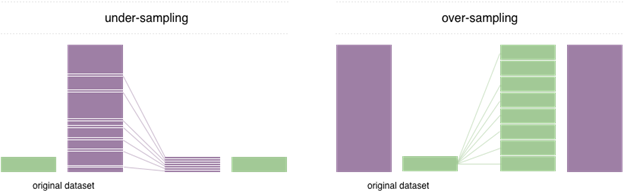

We will used **Imbalanced Dataset Sampler** as proposed by **MIT License** at [12], which is a Pytorch sampler that able to :
-	rebalance the class distributions when sampling from the imbalanced dataset.
-	estimate the sampling weights automatically.
-	avoid creating a new balanced dataset.
-	**mitigate overfitting when it is used in conjunction with data augmentation techniques**.


### Resampling without Augmentation

In [ ]:
from torchsampler import ImbalancedDatasetSampler

In [ ]:
# Data Assignment 
input_size  = 256*256  # images are 256x256 pixels
output_size = 4      # there are 4 classes - Normal, Covid, Lung_Opacity, Viral Pneumonia
def get_data(data_dir):
  train_transform =transforms.Compose([  
      transforms.Resize(size = (224,224)),
      # transforms.CenterCrop(224),
      # transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])

  test_transform = transforms.Compose([
      transforms.Resize(size = (224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])

  # train_set = datasets.ImageFolder(data_dir + '/training_set_balance' , transform=train_transform)
  # test_set = datasets.ImageFolder(data_dir + '/test_set_balance', transform=test_transform)
  # val_set = datasets.ImageFolder(data_dir + '/valid_set_balance', transform=test_transform)
  train_set = datasets.ImageFolder(data_dir + '/training_set' , transform=train_transform)
  test_set = datasets.ImageFolder(data_dir + '/test_set', transform=test_transform)
  val_set = datasets.ImageFolder(data_dir + '/valid_set', transform=test_transform)
  train =  torch.utils.data.DataLoader(train_set,sampler=ImbalancedDatasetSampler(train_set),batch_size=50)
  test =  torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
  val =  torch.utils.data.DataLoader(val_set, batch_size=50, shuffle=True)  

  dataloaders={'train':train,'val':val,'test':test}
  dataset_sizes = {'train':len(train_set),'val':len(val_set),'test':len(test_set)}
  class_names = train_set.classes

  return dataloaders,dataset_sizes,class_names,train_set

# Pathes of Data
save_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/Saved_data_4C'
data_dir ='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/COVID-19_Radiography_Dataset_4C'

# save_path='C:\\Users\\Ahat\\Desktop\\Dor\\Saved_data_4C'
# data_dir ='C:\\Users\\Ahat\\Desktop\\Dor\\COVID-19_Radiography_Dataset_4C'

# Prepare Data
dataloaders,dataset_sizes,class_names,train_set=get_data(data_dir)

#Save Data
torch.save(dataloaders,save_path + '/dataloaders.pt')
torch.save(train_set,save_path + '/trainset.pt')
torch.save(dataset_sizes,save_path + '/dataset_sizes.pt')
torch.save(class_names,save_path + '/class_names.pt')

train,val,test=dataloaders['train'],dataloaders['val'],dataloaders['test']

# What the different between 'train'(DataLoader) and 'train_set'(datasets)

In [ ]:
 # Data types
# print(type(train),type(test),type(val),type(train_set))
# number of images
print("train size=",dataset_sizes['train'])
print("val size=",dataset_sizes['val'])
print("test size=",dataset_sizes['test'])

# num of training Batches
print('Num of training batches', len(train))
print("Num of val batches", len(val))
print("Num of test batches", len(test))

In [ ]:
train.dataset.class_to_idx

In [ ]:
classes=train.dataset.classes
occurnces={classes[i]:train.dataset.targets.count(i) for i in range(len(classes))}
occurnces

In [ ]:
dicts={'a':1}
dicts['a']+=1
dicts.update({'b':1})
dicts=train.dataset.classes
dicts

In [ ]:
data=train
sampels=data.dataset.class_to_idx
for i in range(len(classes)):
  sampels[classes[i]]=0
sampels

In [ ]:
def num_of_sampels(data, classes):
  dataiter = iter(data)
  sampels=data.dataset.class_to_idx
  for i in range(len(classes)):
    sampels[classes[i]]=0
  classes=tuple(classes)
  for j in range(len(data)):
    _,labels = dataiter.next()
    for i,label in enumerate(labels):
      sampels[classes[label]]+=1
    print(sampels)
num_of_sampels(train,classes)

##### CNN 20 try - Resampling + ascending + 64 features + lr=0.0001 + step=12


In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=64
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C/Weights_CNN_1st_try_ascending'
              ,sim_num = '64_features'
              ,load_flag = False
              ,loading_path=None)

In [ ]:
CNN_1st_try_ascending_128=CNN_1st_try_ascending(3,64,4)
CNN_1st_try_ascending_128 = CNN_1st_try_ascending_128.to(device)
# summary(CNN_1st_try_ascending_128, (3, 224, 224))
# checkpoint_optimizer_CNN_1st_try_model_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C/ckpt-26.pk_best_model_wts'
CNN_1st_try_ascending_128.load_state_dict(torch.load('/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C/Weights_CNN_1st_try_ascending_best_model_wts'))
CM, CR = get_confusion_matrix(CNN_1st_try_ascending_128,test)
print("Report")
print("-"*7)
print(CR)
plot_confusion_matrix(CM, list(train_set.class_to_idx.keys()))

In [ ]:
print_specificity(get_specificity(CM, list(train_set.class_to_idx.keys())),list(train_set.class_to_idx.keys()))

##### CNN 21 try - Resampling + ascending + 128 features + lr=0.0001 + step=12


In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C'
              ,sim_num = '64_features'
              ,load_flag = False
              ,loading_path=None)

### Resampling with Augmentation V1

In [ ]:
# Data Assignment 
input_size  = 256*256  # images are 256x256 pixels
output_size = 4      # there are 4 classes - Normal, Covid, Lung_Opacity, Viral Pneumonia
def get_data(data_dir):
  train_transform =transforms.Compose([  
      transforms.Resize(size = (224,224)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomRotation(degrees=(-5,5)),
      transforms.ColorJitter(brightness=0.1,contrast=0.1,hue=0.1),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])  # Why these values?
  ])

  test_transform = transforms.Compose([
      transforms.Resize(size = (224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])

  # train_set = datasets.ImageFolder(data_dir + '/training_set_balance' , transform=train_transform)
  # test_set = datasets.ImageFolder(data_dir + '/test_set_balance', transform=test_transform)
  # val_set = datasets.ImageFolder(data_dir + '/valid_set_balance', transform=test_transform)
  train_set = datasets.ImageFolder(data_dir + '/training_set' , transform=train_transform)
  test_set = datasets.ImageFolder(data_dir + '/test_set', transform=test_transform)
  val_set = datasets.ImageFolder(data_dir + '/valid_set', transform=test_transform)
  train =  torch.utils.data.DataLoader(train_set,sampler=ImbalancedDatasetSampler(train_set),batch_size=50)
  test =  torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
  val =  torch.utils.data.DataLoader(val_set, batch_size=50, shuffle=True)  

  dataloaders={'train':train,'val':val,'test':test}
  dataset_sizes = {'train':len(train_set),'val':len(val_set),'test':len(test_set)}
  class_names = train_set.classes

  return dataloaders,dataset_sizes,class_names,train_set

# Pathes of Data
save_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/Saved_data_4C'
data_dir ='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/COVID-19_Radiography_Dataset_4C'

# save_path='C:\\Users\\Ahat\\Desktop\\Dor\\Saved_data_4C'
# data_dir ='C:\\Users\\Ahat\\Desktop\\Dor\\COVID-19_Radiography_Dataset_4C'

# Prepare Data
dataloaders,dataset_sizes,class_names,train_set=get_data(data_dir)

#Save Data
torch.save(dataloaders,save_path + '/dataloaders.pt')
torch.save(train_set,save_path + '/trainset.pt')
torch.save(dataset_sizes,save_path + '/dataset_sizes.pt')
torch.save(class_names,save_path + '/class_names.pt')

train,val,test=dataloaders['train'],dataloaders['val'],dataloaders['test']

# What the different between 'train'(DataLoader) and 'train_set'(datasets)

In [ ]:
 # Data types
# print(type(train),type(test),type(val),type(train_set))
# number of images
print("train size=",dataset_sizes['train'])
print("val size=",dataset_sizes['val'])
print("test size=",dataset_sizes['test'])

# num of training Batches
print('Num of training batches', len(train))
print("Num of val batches", len(val))
print("Num of test batches", len(test))

##### CNN 22 try - Resampling + Aug (V1) + ascending + 128 features + lr=0.0001 + step=12


In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 23 try - Resampling + Aug (V1) + ascending + 128 features + lr=0.0001 + step=7

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=7
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 24 try - Resampling + Aug (V1) + ascending + 64 features + lr=0.0001 + step=12

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=64
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

### Resampling with Augmentation V2

In [ ]:
# Data Assignment 
input_size  = 256*256  # images are 256x256 pixels
output_size = 4      # there are 4 classes - Normal, Covid, Lung_Opacity, Viral Pneumonia
def get_data(data_dir):
  train_transform =transforms.Compose([  
      transforms.Resize(size = (224,224)),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.RandomRotation(degrees=(-5,5)),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])

  test_transform = transforms.Compose([
      transforms.Resize(size = (224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])

  # train_set = datasets.ImageFolder(data_dir + '/training_set_balance' , transform=train_transform)
  # test_set = datasets.ImageFolder(data_dir + '/test_set_balance', transform=test_transform)
  # val_set = datasets.ImageFolder(data_dir + '/valid_set_balance', transform=test_transform)
  train_set = datasets.ImageFolder(data_dir + '/training_set' , transform=train_transform)
  test_set = datasets.ImageFolder(data_dir + '/test_set', transform=test_transform)
  val_set = datasets.ImageFolder(data_dir + '/valid_set', transform=test_transform)
  train =  torch.utils.data.DataLoader(train_set,sampler=ImbalancedDatasetSampler(train_set),batch_size=50)
  test =  torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
  val =  torch.utils.data.DataLoader(val_set, batch_size=50, shuffle=True)  

  dataloaders={'train':train,'val':val,'test':test}
  dataset_sizes = {'train':len(train_set),'val':len(val_set),'test':len(test_set)}
  class_names = train_set.classes

  return dataloaders,dataset_sizes,class_names,train_set

# Pathes of Data
# save_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/Saved_data_4C'
# data_dir ='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/COVID-19_Radiography_Dataset_4C'

save_path='C:\\Users\\Ahat\\Desktop\\Dor\\Saved_data_4C'
data_dir ='C:\\Users\\Ahat\\Desktop\\Dor\\COVID-19_Radiography_Dataset_4C'

# Prepare Data
dataloaders,dataset_sizes,class_names,train_set=get_data(data_dir)

#Save Data
torch.save(dataloaders,save_path + '/dataloaders.pt')
torch.save(train_set,save_path + '/trainset.pt')
torch.save(dataset_sizes,save_path + '/dataset_sizes.pt')
torch.save(class_names,save_path + '/class_names.pt')

train,val,test=dataloaders['train'],dataloaders['val'],dataloaders['test']

# What the different between 'train'(DataLoader) and 'train_set'(datasets)

In [ ]:
 # Data types
# print(type(train),type(test),type(val),type(train_set))
# number of images
print("train size=",dataset_sizes['train'])
print("val size=",dataset_sizes['val'])
print("test size=",dataset_sizes['test'])

# num of training Batches
print('Num of training batches', len(train))
print("Num of val batches", len(val))
print("Num of test batches", len(test))

##### CNN 25 try - Resampling + Aug (V2) + ascending + 128 features + lr=0.0001 + step=12

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 26 try - Resampling + Aug (V2) + ascending + 128 features + lr=0.0001 + step=7

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=7
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 27 try - Resampling + Aug (V2) + ascending + 64 features + lr=0.0001 + step=12

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=64
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

## "Not on fly" Augmentation

### Augmentation for minority classes

In [ ]:
# Data Assignment 
input_size  = 256*256  # images are 256x256 pixels
output_size = 4      # there are 4 classes - Normal, Covid, Lung_Opacity, Viral Pneumonia
def get_data(data_dir):
  train_transform =transforms.Compose([  
      transforms.Resize(size = (224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])

  test_transform = transforms.Compose([
      transforms.Resize(size = (224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])

  # train_set = datasets.ImageFolder(data_dir + '/training_set_balance' , transform=train_transform)
  # test_set = datasets.ImageFolder(data_dir + '/test_set_balance', transform=test_transform)
  # val_set = datasets.ImageFolder(data_dir + '/valid_set_balance', transform=test_transform)
  train_set = datasets.ImageFolder(data_dir + '/‏‏training_set_Aug' , transform=train_transform)
  test_set = datasets.ImageFolder(data_dir + '/test_set', transform=test_transform)
  val_set = datasets.ImageFolder(data_dir + '/valid_set', transform=test_transform)
  train =  torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True)
  test =  torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
  val =  torch.utils.data.DataLoader(val_set, batch_size=50, shuffle=True)  

  dataloaders={'train':train,'val':val,'test':test}
  dataset_sizes = {'train':len(train_set),'val':len(val_set),'test':len(test_set)}
  class_names = train_set.classes

  return dataloaders,dataset_sizes,class_names,train_set

# Pathes of Data
save_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/Saved_data_4C'
data_dir ='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/COVID-19_Radiography_Dataset_4C'

# save_path='C:\\Users\\Ahat\\Desktop\\Dor\\Saved_data_4C'
# data_dir ='C:\\Users\\Ahat\\Desktop\\Dor\\COVID-19_Radiography_Dataset_4C'

# Prepare Data
dataloaders,dataset_sizes,class_names,train_set=get_data(data_dir)

#Save Data
torch.save(dataloaders,save_path + '/dataloaders.pt')
torch.save(train_set,save_path + '/trainset.pt')
torch.save(dataset_sizes,save_path + '/dataset_sizes.pt')
torch.save(class_names,save_path + '/class_names.pt')

train,val,test=dataloaders['train'],dataloaders['val'],dataloaders['test']

# What the different between 'train'(DataLoader) and 'train_set'(datasets)

In [ ]:
 # Data types
# print(type(train),type(test),type(val),type(train_set))
# number of images
print("train size=",dataset_sizes['train'])
print("val size=",dataset_sizes['val'])
print("test size=",dataset_sizes['test'])

# num of training Batches
print('Num of training batches', len(train))
print("Num of val batches", len(val))
print("Num of test batches", len(test))

In [ ]:
classes=train.dataset.classes
occurnces={classes[i]:train.dataset.targets.count(i) for i in range(len(classes))}
occurnces

##### CNN 28 try - not on fly Aug + ascending + 128 features + lr=0.0001 + step=12

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 29 try - not on fly Aug + ascending + 128 features + lr=0.0001 + step=7

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=20
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-7
              ,step_size_val=4
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 30 try - not on fly Aug + ascending + 64 features + lr=0.0001 + step=12

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=64
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

### Augmentation for all classes

In [ ]:
# Data Assignment 
input_size  = 256*256  # images are 256x256 pixels
output_size = 4      # there are 4 classes - Normal, Covid, Lung_Opacity, Viral Pneumonia
def get_data(data_dir):
  train_transform =transforms.Compose([  
      transforms.Resize(size = (224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])  # Why these values?
  ])

  test_transform = transforms.Compose([
      transforms.Resize(size = (224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                      std = [0.229, 0.224, 0.225])
  ])

  # train_set = datasets.ImageFolder(data_dir + '/training_set_balance' , transform=train_transform)
  # test_set = datasets.ImageFolder(data_dir + '/test_set_balance', transform=test_transform)
  train_set = datasets.ImageFolder('/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/COVID-19_Radiography_Dataset_4C/‏‏training_set_Aug_for_trans', transform=train_transform)
  test_set = datasets.ImageFolder(data_dir + '/test_set', transform=test_transform)
  val_set = datasets.ImageFolder(data_dir + '/valid_set', transform=test_transform)
  train =  torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True)
  test =  torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
  val =  torch.utils.data.DataLoader(val_set, batch_size=50, shuffle=True)  

  dataloaders={'train':train,'val':val,'test':test}
  dataset_sizes = {'train':len(train_set),'val':len(val_set),'test':len(test_set)}
  class_names = train_set.classes

  return dataloaders,dataset_sizes,class_names,train_set

# Pathes of Data
save_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/Saved_data_4C'
data_dir ='/content/gdrive/MyDrive/DeepLearning/Final_Project/Data/COVID-19_Radiography_Dataset_4C'

# save_path='C:\\Users\\Ahat\\Desktop\\Dor\\Saved_data_4C'
# data_dir ='C:\\Users\\Ahat\\Desktop\\Dor\\COVID-19_Radiography_Dataset_4C'

# Prepare Data
dataloaders,dataset_sizes,class_names,train_set=get_data(data_dir)

#Save Data
torch.save(dataloaders,save_path + '/dataloaders.pt')
torch.save(train_set,save_path + '/trainset.pt')
torch.save(dataset_sizes,save_path + '/dataset_sizes.pt')
torch.save(class_names,save_path + '/class_names.pt')

train,val,test=dataloaders['train'],dataloaders['val'],dataloaders['test']

# What the different between 'train'(DataLoader) and 'train_set'(datasets)

In [ ]:
 # Data types
# print(type(train),type(test),type(val),type(train_set))
# number of images
print("train size=",dataset_sizes['train'])
print("val size=",dataset_sizes['val'])
print("test size=",dataset_sizes['test'])

# num of training Batches
print('Num of training batches', len(train))
print("Num of val batches", len(val))
print("Num of test batches", len(test))

In [ ]:
classes=train.dataset.classes
occurnces={classes[i]:train.dataset.targets.count(i) for i in range(len(classes))}
occurnces

##### CNN 31 try - not on fly Aug + ascending + 128 features + lr=0.0001 + step=12

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='/content/gdrive/MyDrive/DeepLearning/Final_Project/Weights_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 32 try - not on fly Aug + ascending + 128 features + lr=0.0001 + step=7

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=128
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=7
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

##### CNN 33 try - not on fly Aug + ascending + 64 features + lr=0.0001 + step=12

In [ ]:
# unbalanced data
Run_Simulation(architecture=CNN_1st_try_ascending 
              ,architecture_name = "CNN_1st_try_ascending"
              ,num_epochs=30
              ,n_features=64
              ,output_size=4
              ,optimizer_name="Adam"
              ,lr_val=0.0001
              ,weight_decay_val=1e-9
              ,step_size_val=12
              ,gamma_val=0.1
              ,momentum_val=0.9
              ,checkpoint_optimizer_path='C:\\Users\\Ahat\\Desktop\\Dor\\Weigths_4C'
              ,sim_num = '128_features'
              ,load_flag = False
              ,loading_path=None)

#Result Analysis

As before, and since we imitate the Architecture and techniques used in the 1st stage, we can observe that the most **Significant Actions** taken were **learning rate decay**, **Adam optimizer**, **ascending number of filters** and in addition **Augmentation**. 

As before, several regularization techniques were used to improve the model by preventing the overfitting phenomena: **Early Stoppings**, Regularization Using **Dropout** and **Batch Normalization** layers, Apply Regularization term which boils down to adding a cost to the loss function – **weight decay, learning rate decay.**

**Distinguish between "Normal" and "Lung opacity":**
All the tested models including the state-of-the-art models are prone to classify ="**Lung Opacity**" class samples as belong to " **NORMAL** " class, which lead to low recall and specificity for both of the classes, and as a result low F1-score.

Highest "Lung opacity" recall encountered: 93%

Highest "Normal" recall encountered: 96%

**The reason** behind that is that in chest radiographs, NORMAL lungs appear dark due to the relative lower density of air compared to the surrounding tissues. 

since even a **minor** size area where air is replaced by another substance causing the tissue to appear **lighter or greyer** – labeled as "**Lung Opacity**", there is a very small gap between "**Lung opacity**" image sample and a "**Normal**" image sample with added noise.


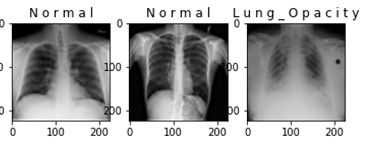

**Abilities in minority classes:**

All the presented models achieve better recall for the smallest Minorities classes i.e. the "**Viral pneumonia**" and the "**COVID-19**" classes than for the majority classes. There could be few reasons behind it but the Most likely is that the initial model is the same Architecture used for the 1st stage where the ability of the model to detect "COVID" class samples is magnificent.  

**Initial number of Features:**

the raise in the number of initial filters from 32 to 64 and 128 significantly improved the performances of our model, especially the recall of the majority class i.e. the "**NORMAL**" class. 

**Regularization:**

We have noticed that the addition of initial number of features and Regularization techniques such as learning rate decay lead significantly improved the performances of our model, especially the recall of the majority class i.e., the "**NORMAL**".

However, higher regularization caused to reduce in the ability of the model to classify the 2nd major class "**Lung Opacity**".
As a result, Since for higher regularization i.e. frequent learning rate decay we ger higher recall  for "**Normal**" class and smaller recall for "**Lung Opacity**" class, we receive smaller specificity for the major class i.e. the ability of the model to classify other classes samples not as "**Normal**" class is Impaired (most affected by the 2nd major class – "**Lung opacity**")
Alternatively, for less regularization, we get better recall for "**Lung opacity**" class and worse specificity for "**Normal**" class. 

We can learn from this insight the moderate learning rate decay i.e. step size = 12 produced the Best performances in the manner of balance between metrics. We can also notice that higher regularization caused to better F1-scores for our model.


**Prone to overfitting:**

*For less regularization* - we notice to notable gap between the validation and the training loss curves.

*For no learning decay at all*- we get fatal overfitting – where the model stops improving from the first epochs (~8-10)

*Higher Regularization* - much less tendency to overfitting. 

**Learning rate:**

The optimal learning rate is given by 0.0001 where for higher learning rate the model achieves poor results. 

**Augmentation:**

Several Augmentation techniques were integrated in the pre-processing stage, as a clinical input for been take in consideration as reported broadly above. We can notice that:

*Ver #1:* The integration of Rotation in the range of ±5° by itself improved the ability to correctly detect the majority classes samples while produce worse the minority classes. ability to correctly detect

*Ver #2:* The combination of **Rotation** in the range of ±5° and **Mirroring** in the y-axis as a "**On fly Augmentation**" yield the best model performances so far as the model performs the **best f1-score**, the **best specificity** for the both the majority classes and - "**Lung Opacity**" class and "**NORMAL**" classes and recall of 98% for both the minority classes.

*Ver #3:* The addition of **Color Jitter** augmentation i.e., the combination of **Rotation** + **Mirroring** + **ColorJitter** yield even better ability to correctly detect the majority classes samples, but it significantly reduced the ability of the model to identify correctly "**COVID-19**" class samples.

Using data augmentation, a lot of similar images has been generated "on fly". As a result the model is unable to overfit all the samples, and is forced to generalize – our models are much less prone to overfit.

**Resampling Data:**

Even though the usage of regularization mechanism such as learning rate decay and weight decay we can notice that the Resampling only models presented in 20-21 try are suffering from high overfitting which yield the Imbalanced data sampler technique which produces balancing classes and cause to a loss of information by under sampling and a tendency to over fitting by oversampling.

The resampling also produces high ability to detect correctly "**COVID-19**" class samples, In contrast to Augmentation, but lower performances in a manner of all other tested metrics.

**Resampling +Augmentation:**

the **combination** of balanced sampling and augmentation for given number of initial features 64 and 128 with higher regularization reduces significantly the gap between curves i.e. the tendency of the model to overfit.

The Combination of balanced sampling and the **Color Jitter** augmentation yield even better ability of our model to classify correctly "**Lung opacity**" samples but reduced the ability of the model to identify correctly "**COVID-19**" class samples. However, the usage of resampling makes it better then it performed by the models that only affected by color jitter augmentation.

The removal of **Color Jitter** yield the **best** model so far, which comprised for less parameter the the leading model (#16 , 128 parameters), by achieving better ability to detect "**COVID-19**" and "**Normal**" class samples, best f1-scores so and similar performances comparing to model #16.

**"Not on fly" Augmentation:**

The added augmented samples caused to reduce in the ability of the model to correctly detect the 2nd major class doesn’t improved the detection ability of the other classes in comparison to "on fly" augmentation. The addition "**Lung opacity**" samples does improved the ability of the model with relation to the majority classes but yet it is evident that the "not on fly" Augmentation isn’t effective technique for our mission.


#Conclusion
This project dealt with the field of Image classification using Convolutional Neural Networks Architectures as the leading techniques for this kind of missions. 

Due to the spatial structure Preserve - CNNs can be thought of automatic feature extractors from the image by effectively uses adjacent pixel information to effectively down sample the image first by convolution and then uses a prediction layer at the end. 

In this project we dealt a two-stage classification task.

In the 1st stage, the task was to classify an X-Ray scan of a person's lungs into one of two classes - healthy people which represented as **“Normal”** class and positive to Covid-19 patient which represented as “**Covid-19**” class. 

In the 2nd stage we faced with a classification task of four different classes - “**Normal**” and “**Covid-19**” classes (as in the first stage) and in addition, we dealt with lung X-Ray scans of people positive to Viral Pneumonia and lung opacity diseases which represented as “**Viral Pneumonia**“ and “**Lung Opacity**” classes, respectively. 

The data that used for this task were taken from COVID-19 Radiography Database - COVID-19 Chest X-ray Database (Rahman, 2021), were the main challenge is that the data is comprised from imbalance amount of sample in each class. For example, the major class **“Normal”** is almost ten times larger than the minor class “**Viral Pneumonia**”. The data were divided into 70% for training, 10% for the validation and 20% for the testing.

To tackle this challenge, we define the right evaluation **metrics**, we used different **Regularization** techniques such as **Early Stoppings, Dropout** and **Batch Normalization** layers, learning rate and weight **Decay**, Reduction the **Network Capacity**, we defined and test different **Architectures**, we used **Resampling** and we integrated **Augmentations** for both on fly and non-on fly preprocessing methods.


In the 1st stage we design a model that comprised from 5 convolutional block with ascending number of filters (initial 32), Adam optimizer, and 10 time less parameters than the state-of-the-art model VGG16.

Our model reaches higher **Accuracy** than VGG16 and similar to ResNet18, **Higher Sensitivity** than both ResNet and VGG16. **Higher precision** than ResNet18 and **Higher F1-Score** than VGG16 which mean we have more balance between Precision and Recall. 

In the 2nd stage we design a model that imitates the architecture which used in the first stage, i.e. 5 convolutional blocks, ascending number of filters (64) and Adam optimizer. In addition, we integrated as a pre-processing stage of combination between balanced sampling and ‘on the fly’ augmentation which achieves similar performances as state-of-the-art VGG16 yields for “**covid-19**” and “**Normal**” classes and better results for “**Viral Pneumonia**” class.   

As we noticed, the most **significant factors** for improving the model ability to detect correctly the classes were the integration of **Adam optimizer** and **ascending number of features** between the convolutional layers. the addition of **Augmentation** and **Resampling** technique helped to achieve more accurate and less prone to overfitting model.

**The proposed models in this project provide improvement in today’s abilities to deal with X-Ray lungs damages classification tasks and stands in one line among the state-of-the-art models.** 


#Bibliography
Ahsan, M. B. (2021). COVID-19 detection from chest X-ray images using feature fusion and deep learning. Sensors, 21(4), 1480.

Borda. (2021, 7 26). Imbalanced Dataset Sampler. Retrieved from github.com: https://github.com/ufoym/imbalanced-dataset-sampler

Brownlee, J. (2021, 7 26). A Gentle Introduction to Dropout for Regularizing Deep Neural Networks. Retrieved from machinelearningmastery.com: https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

Elgendi, M., Nasir, M. U., Tang, Q., & Smith, D. (2021, 7 26). The Effectiveness of Image Augmentation in Deep Learning Networks for Detecting COVID-19: A Geometric Transformation Perspective. Retrieved from frontiersin.org: https://www.frontiersin.org/articles/10.3389/fmed.2021.629134/full

Jason, B. (2021, 7 26). Failure of Classification Accuracy for Imbalanced Class Distributions. Retrieved from machinelearningmastery.com: https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/

Kautza, T., Cristian, B. M., & F.Pasluosta. (2017). Generic performance measure for multiclass-classifiers. Elsevier Pattern Recognition (68) , 111-125.

Rahman, T. (2021, 7 26). COVID-19 Radiography Database. Retrieved from kaggle: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

SAXENA, S. (2021, 7 26). Image Augmentation Techniques for Training Deep Learning Models. Retrieved from analyticsvidhya.com: https://www.analyticsvidhya.com/blog/2021/03/image-augmentation-techniques-for-training-deep-learning-models/

Vaughan, D. (2021, 7 26). Multiclass averaging. Retrieved from cran.r-project.org: https://cran.r-project.org/web/packages/yardstick/vignettes/multiclass.html

Vu, C. (2021, 7 26). Do and don’t when using transformation to improve CNN deep learning model. Retrieved from towardsdatascience.com: https://towardsdatascience.com/improves-cnn-performance-by-applying-data-transformation-bf86b3f4cef4

Wu, Y., & Radewagen, R. (2021, 7 26). 7 Techniques to Handle Imbalanced Data. Retrieved from kdnuggets.com: https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html

